In [1]:
import pandas as pd
import numpy as np
import os
from acquire import get_hwyrail, get_equiprail
from prepare import prep_hwy_df, prep_equip_df
import json
from typing import Dict, List, Optional, Union, cast
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import unicodedata
import re

# visualize

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = get_hwyrail()

In [3]:
df.RAILROAD.value_counts()

UP      3377
CSX     3128
NS      3054
BNSF    2536
ATK     1233
        ... 
FNOR       1
CJR        1
DL         1
CERA       1
GRWR       1
Name: RAILROAD, Length: 433, dtype: int64

In [4]:
df.shape

(18995, 104)

In [5]:
counts = df['RAILROAD'].value_counts()

newdf = df[~df['RAILROAD'].isin(counts[counts < 500].index)]

In [6]:
newdf.RAILROAD.value_counts()

UP      3377
CSX     3128
NS      3054
BNSF    2536
ATK     1233
KCS      501
Name: RAILROAD, dtype: int64

In [7]:
#create dataframe of just railroad and narratives
nlpdf = newdf[['RAILROAD','NARR1','NARR2','NARR3','NARR4','NARR5' ]]

In [8]:
#replace NaN with empty string spaces

nlpdf = nlpdf.replace(np.nan, '', regex=True)

In [9]:
#merge all narrative columns into 1 single column

nlpdf["narrative"] = nlpdf["NARR1"] + nlpdf["NARR2"] + nlpdf["NARR3"] + nlpdf["NARR4"] + nlpdf["NARR5"]

In [10]:
#drop unneeded narrative columns as they have already been merged

nlpdf = nlpdf.drop(['NARR1', 'NARR2', 'NARR3', 'NARR4', 'NARR5'], axis=1)

In [11]:
#find narratives with nulls
null_narrative = nlpdf[nlpdf['narrative'].isnull()].index

In [12]:
#drop any null narratives
df.drop(null_narrative , inplace=True)

In [13]:
def clean_nlp(narrative):
    
    'A simple function to cleanup text data'
    
    ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt', '\n', 'ha']
    
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')+ ADDITIONAL_STOPWORDS
    narrative = (unicodedata.normalize('NFKD', narrative)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', narrative).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [14]:
railroads = pd.concat([nlpdf.RAILROAD.value_counts(),
                    nlpdf.RAILROAD.value_counts(normalize=True)], axis=1)
railroads.columns = ['n', 'percent']

railroads

,n,percent
UP,3377,0.244197
CSX,3128,0.226191
NS,3054,0.220840
BNSF,2536,0.183383
ATK,1233,0.089160
KCS,501,0.036228


In [15]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(nlpdf, "RAILROAD")

,n,percent
UP,3377,0.244197
CSX,3128,0.226191
NS,3054,0.220840
BNSF,2536,0.183383
ATK,1233,0.089160
KCS,501,0.036228


------------

## TAKEAWAY

- UP, CSX, NS, BNSF all have similar amount of incidents

In [16]:
nlpdf.RAILROAD.value_counts()

UP      3377
CSX     3128
NS      3054
BNSF    2536
ATK     1233
KCS      501
Name: RAILROAD, dtype: int64

In [17]:
up_ = clean_nlp(' '.join(nlpdf[nlpdf.RAILROAD == 'UP'].narrative))

In [18]:
nlpdf[nlpdf.RAILROAD == 'UP']

,RAILROAD,narrative


In [19]:
nlpdf.head()

,RAILROAD,narrative
0,UP,HIEHWAY USER'S ACTIONS: STOPPED ON CROSSING ( ...
1,UP,HIGHWAY USER'S ACTIONS: STOPPED ON CROSSING ( ...
2,BNSF,DRIVER AGE UNKNOW. 41: ABANDONED VEHICLE
3,BNSF,12/18/12 PER CONTRA COSTA COUNTY CORONERS REPO...
4,BNSF,


In [20]:
# seperate the data into seperate pieces 

up = clean_nlp(' '.join(nlpdf[nlpdf.RAILROAD == 'UP  '].narrative))

csx = clean_nlp(' '.join(nlpdf[nlpdf.RAILROAD == 'CSX '].narrative))

ns = clean_nlp(' '.join(nlpdf[nlpdf.RAILROAD == 'NS  '].narrative))

bnsf = clean_nlp(' '.join(nlpdf[nlpdf.RAILROAD == 'BNSF'].narrative))

atk = clean_nlp(' '.join(nlpdf[nlpdf.RAILROAD == 'ATK '].narrative))

kcs = clean_nlp(' '.join(nlpdf[nlpdf.RAILROAD == 'KCS '].narrative))

allrails = clean_nlp(' '.join(nlpdf.narrative))

In [21]:
# transform into a pandas series

up_freq = pd.Series(up).value_counts()

csx_freq = pd.Series(csx).value_counts()

ns_freq = pd.Series(ns).value_counts()

bnsf_freq = pd.Series(bnsf).value_counts()

atk_freq = pd.Series(atk).value_counts()

kcs_freq = pd.Series(kcs).value_counts()

all_freq = pd.Series(allrails).value_counts()

up_freq.head()

user        2904
highway     2887
action      2550
gate        1770
crossing    1705
dtype: int64

In [22]:
# create a dataframe with all three columns showing frequency counts

word_counts = (pd.concat([all_freq, up_freq, csx_freq, ns_freq, bnsf_freq ,atk_freq, kcs_freq], axis=1, sort=True)
                .set_axis(['all', 'UP', 'CSX', 'NS', 'BNSF', 'ATK', 'KCS'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.tail()

,all,UP,CSX,NS,BNSF,ATK,KCS
zwspatl924,1,0,0,0,1,0,0
zwsplac921l,1,0,0,0,1,0,0
zwspphx922l,1,0,0,0,1,0,0
zwspsbd803l,1,0,0,0,1,0,0
zwspst0817l,1,0,0,0,1,0,0


In [23]:
# sort values by all

word_counts.sort_values(by='all', ascending=False).head(10)

,all,UP,CSX,NS,BNSF,ATK,KCS
crossing,11046,1705,4289,2874,617,1333,228
struck,8588,672,2618,2903,759,1193,443
train,6702,757,695,2786,625,1445,394
vehicle,4639,485,1629,705,611,796,413
user,3738,2904,64,249,441,80,0
highway,3444,2887,119,278,64,94,2
gate,3099,1770,424,244,474,87,100
driver,3043,401,832,812,539,333,126
stop,2986,1029,1471,232,165,12,77
action,2555,2550,5,0,0,0,0


In [24]:
# look for any words that are uniquely spam or ham

pd.concat([word_counts[word_counts.UP == 0].sort_values(by='UP').tail(6),
           word_counts[word_counts.CSX == 0].sort_values(by='CSX').tail(6),
          word_counts[word_counts.NS == 0].sort_values(by='NS').tail(6),
          word_counts[word_counts.BNSF == 0].sort_values(by='BNSF').tail(6),
          word_counts[word_counts.ATK == 0].sort_values(by='ATK').tail(6),
          word_counts[word_counts.KCS == 0].sort_values(by='KCS').tail(6)])

,all,UP,CSX,NS,BNSF,ATK,KCS
allowing,1,0,1,0,0,0,0
alluding,1,0,0,0,1,0,0
alochol,1,0,0,0,0,0,1
alongside,2,0,2,0,0,0,0
alsoat,19,0,19,0,0,0,0
zwspst0817l,1,0,0,0,1,0,0
565c212,1,0,0,1,0,0,0
5655,1,0,0,0,0,0,1
5651,1,0,0,1,0,0,0
564c419,1,0,0,1,0,0,0


In [25]:
# convert UP words to one string

up = ' '.join([str(elem) for elem in up])

In [26]:
#use bigrams to split

bigrams = nltk.ngrams(up.split(), 2)


top_20_up_bigrams = pd.Series(bigrams).value_counts().head(20)

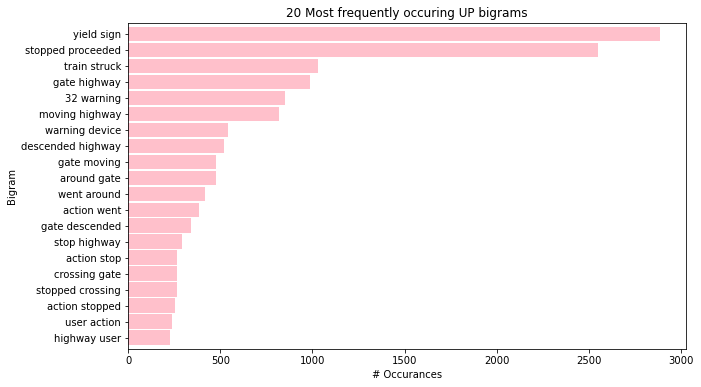

In [28]:
top_20_up_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring UP bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_up_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [29]:
# convert CSX words to one string

csx = ' '.join([str(elem) for elem in csx])

In [30]:
#use bigrams to split

bigrams = nltk.ngrams(csx.split(), 2)

top_20_csx_bigrams = pd.Series(bigrams).value_counts().head(20)

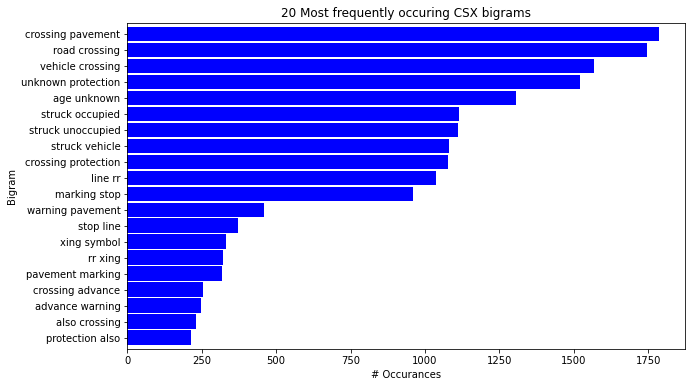

In [32]:
top_20_csx_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring CSX bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_csx_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [33]:
# convert NS words to one string

ns = ' '.join([str(elem) for elem in ns])

In [34]:
#use bigrams to split

bigrams = nltk.ngrams(ns.split(), 2)


top_20_ns_bigrams = pd.Series(bigrams).value_counts().head(20)

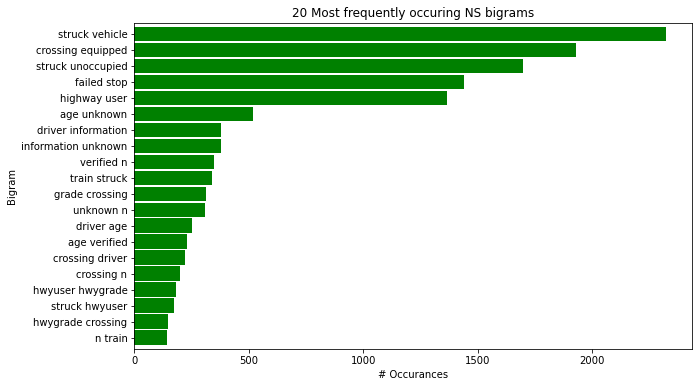

In [35]:
top_20_ns_bigrams.sort_values().plot.barh(color='green', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring NS bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ns_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

--------

In [36]:
# convert BNSF words to one string

bnsf = ' '.join([str(elem) for elem in bnsf])

In [37]:
#use bigrams to split

bigrams = nltk.ngrams(bnsf.split(), 2)


top_20_bnsf_bigrams = pd.Series(bigrams).value_counts().head(20)

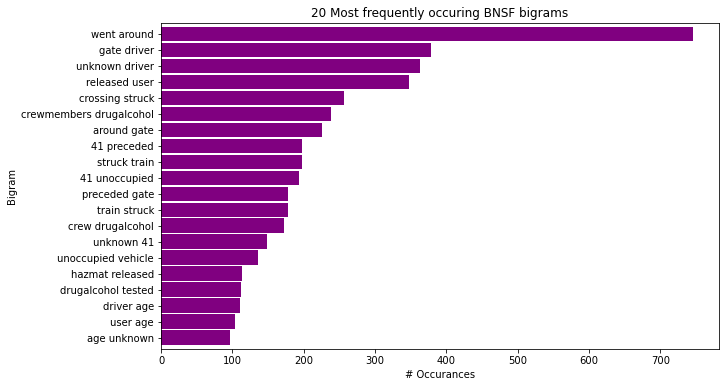

In [38]:
top_20_bnsf_bigrams.sort_values().plot.barh(color='purple', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring BNSF bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_bnsf_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

--------

In [39]:
# convert ATK words to one string

atk = ' '.join([str(elem) for elem in atk])

In [40]:
#use bigrams to split

bigrams = nltk.ngrams(atk.split(), 2)


top_20_atk_bigrams = pd.Series(bigrams).value_counts().head(20)

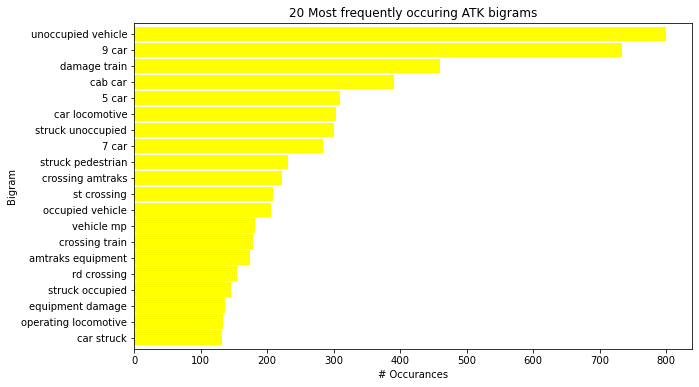

In [41]:
top_20_atk_bigrams.sort_values().plot.barh(color='yellow', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ATK bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_atk_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

-----

In [43]:
# convert KCS words to one string

kcs = ' '.join([str(elem) for elem in kcs])

In [44]:
#use bigrams to split

bigrams = nltk.ngrams(kcs.split(), 2)


top_20_kcs_bigrams = pd.Series(bigrams).value_counts().head(20)

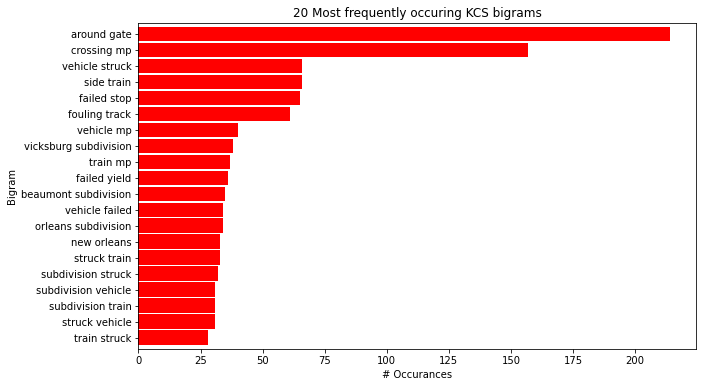

In [45]:
top_20_kcs_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring KCS bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_kcs_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

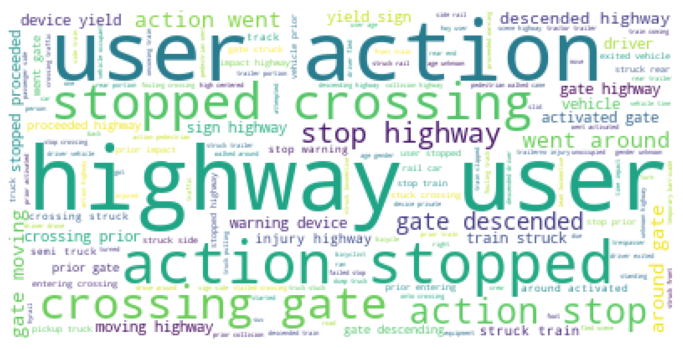

In [48]:
# spam words word cloud

from wordcloud import WordCloud


plt.figure(figsize=(12,10))
img = WordCloud(background_color='white').generate(up)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show()

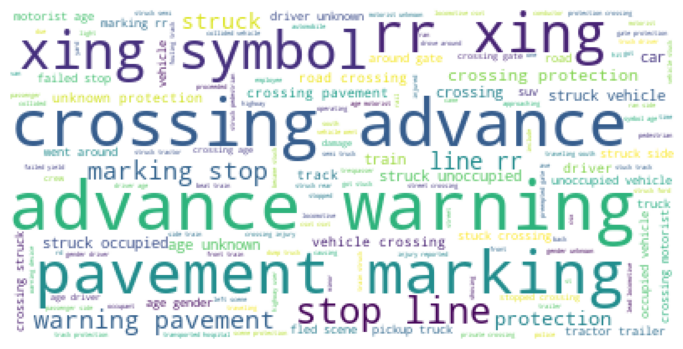

In [49]:
plt.figure(figsize=(12,10))
img = WordCloud(background_color='white').generate(csx)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show()

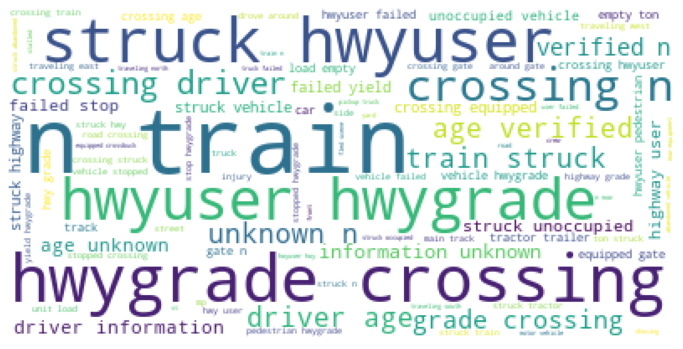

In [50]:
plt.figure(figsize=(12,10))
img = WordCloud(background_color='white').generate(ns)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show()

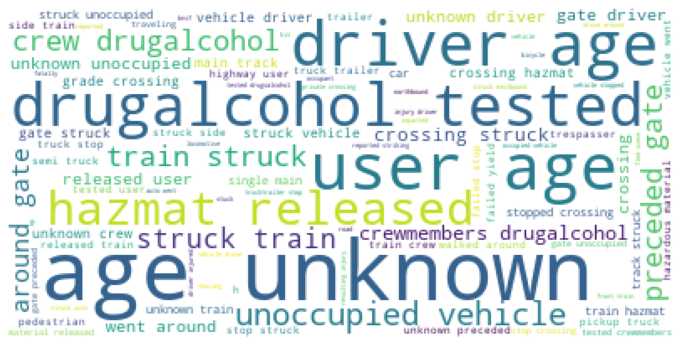

In [51]:
plt.figure(figsize=(12,10))
img = WordCloud(background_color='white').generate(bnsf)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show()

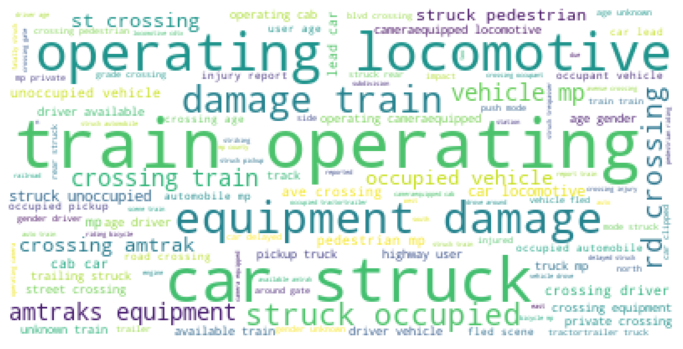

In [52]:
plt.figure(figsize=(12,10))
img = WordCloud(background_color='white').generate(atk)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show()

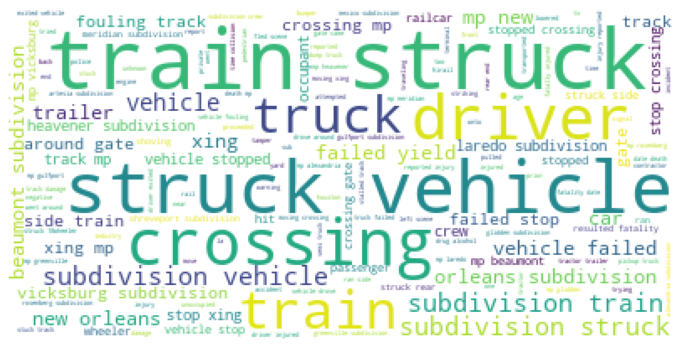

In [53]:
plt.figure(figsize=(12,10))
img = WordCloud(background_color='white').generate(kcs)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show()

---------

Text(0.5, 1.0, 'Proportion of UP vs NS for the 20 most common words')

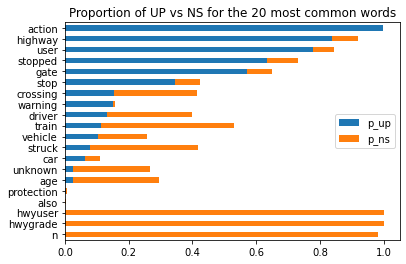

In [64]:
# figure out the percentage of UP vs NS
(word_counts
 .assign(p_up=word_counts.UP / word_counts['all'],
         p_ns=word_counts.NS / word_counts['all'])
 .sort_values(by='all')
 [['p_up', 'p_ns']]
 .tail(20)
 .sort_values('p_up')
 .plot.barh(stacked=True))

plt.title('Proportion of UP vs NS for the 20 most common words')

In [65]:
# figure out the percentage of ATK vs BNSF
(word_counts
 .assign(p_atk=word_counts.ATK / word_counts['all'],
         p_ns=word_counts.BNSF / word_counts['all'])
 .sort_values(by='all')
 [['p_atk', 'p_bnsf']]
 .tail(20)
 .sort_values('p_atk')
 .plot.barh(stacked=True))

plt.title('Proportion of ATK vs BNSF for the 20 most common words')

KeyError: "None of [Index(['p_atk', 'p_bnsf'], dtype='object')] are in the [columns]"